# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    * Deliver an ML system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew. 

## Inputs

* inputs/mildew_dataset/leaves_images/train
* inputs/mildew_dataset/leaves_images/test
* inputs/mildew_dataset/leaves_images/validation
* image shape embeddings.

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.


## Additional Comments

* No additional comments.



---

## Import regular packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, BatchNormalization, MaxPooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import cv2

## Set Working Directory

In [3]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspace/mildew-detection')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection'

## Set output directory

In [6]:
import os

# Define the directory 
work_dir = '/workspace/mildew-detection'

# Find the latest version number
versions = [name for name in os.listdir(os.path.join(work_dir, 'outputs')) if name.startswith('v')]
if versions:
    latest_version = max(versions)
    version_number = int(latest_version[1:]) + 1
else:
    version_number = 1

# Create the new version directory
version = f'v{version_number}'
file_path = os.path.join(work_dir, 'outputs', version)

if not os.path.exists(file_path):
    os.makedirs(file_path)
    print(f'New version {version} created successfully!')
else:
    print('Error: Directory already exists for the new version.')

New version v3 created successfully!


## Set image shape

In [7]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Import DataFrames

In [9]:
import pandas as pd

# Paths to the CSV files previously created
train_csv_path = '/workspace/mildew-detection/train_dataframe.csv'
validation_csv_path = '/workspace/mildew-detection/validation_dataframe.csv'
test_csv_path = '/workspace/mildew-detection/test_dataframe.csv'

# Read the CSV files into dataframes
train_df = pd.read_csv(train_csv_path)
validation_df = pd.read_csv(validation_csv_path)
test_df = pd.read_csv(test_csv_path)

## Number of images in train, test and validation DataFrames

Calculate and plot how many images

Train:
healthy: 1472 images
powdery_mildew: 1472 images
Validation:
healthy: 210 images
powdery_mildew: 210 images
Test:
healthy: 422 images
powdery_mildew: 422 images




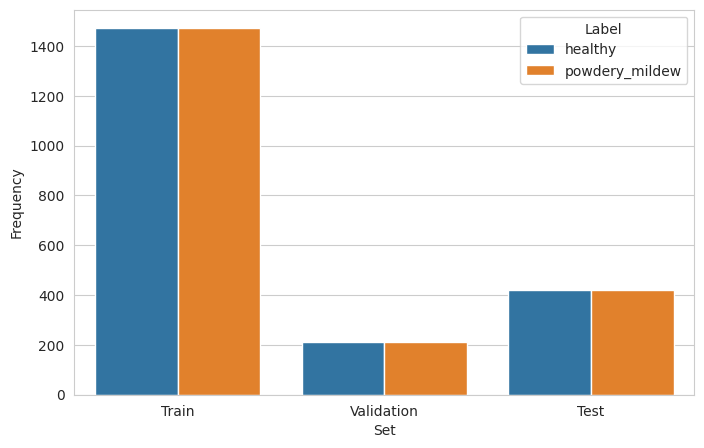

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine all labels from the datasets to get the unique labels
all_labels = pd.concat([train_df['label'], validation_df['label'], test_df['label']])
labels = all_labels.unique()

# Initialize an empty DataFrame
df_freq = pd.DataFrame([])

# Define the datasets
datasets = [('train', train_df), ('validation', validation_df), ('test', test_df)]

# Iterate over each dataset and label to count the occurrences
for dataset_name, dataset_df in datasets:
    # Initialize counts dictionary for each dataset
    dataset_counts = {label: 0 for label in labels}
    
    # Calculate counts for each label in the current dataset
    for label in labels:
        label_count = dataset_df[dataset_df['label'] == label].shape[0]
        dataset_counts[label] = label_count
    
    # Print dataset information
    print(f"{dataset_name.capitalize()}:")
    for label, label_count in dataset_counts.items():
        print(f"{label}: {label_count} images")

    # Append the counts to the df_freq DataFrame
    df_freq = df_freq.append(
        pd.DataFrame({'Set': dataset_name.capitalize(), 'Label': list(dataset_counts.keys()), 'Frequency': list(dataset_counts.values())}),
        ignore_index=True
    )

print("\n")

# Plot the frequency distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

### ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [12]:
data_dir = 'inputs/datasets'
train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [14]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

Train set
Image shape: (256, 256, 3), Label: healthy


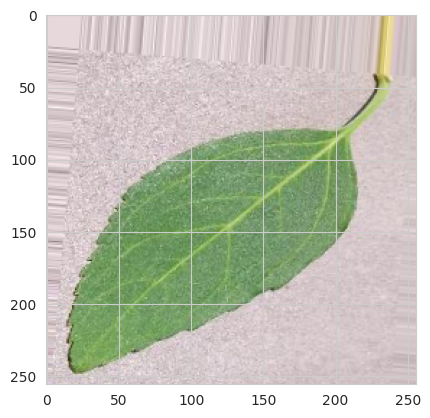

Train set
Image shape: (256, 256, 3), Label: powdery_mildew


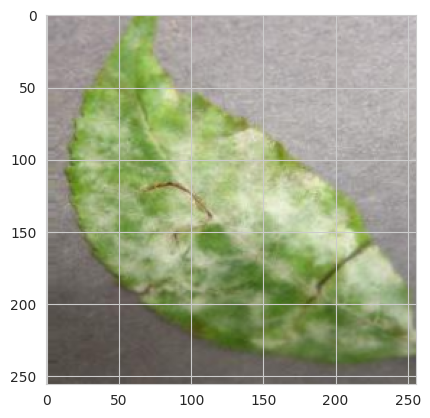

Train set
Image shape: (256, 256, 3), Label: healthy


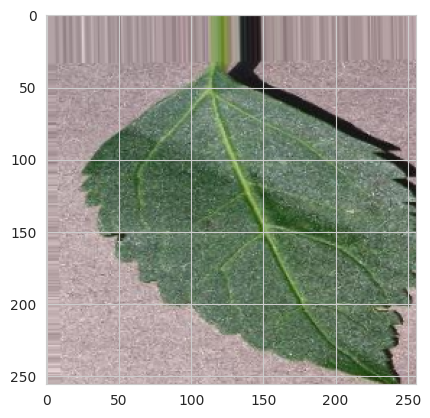

In [28]:
import numpy as np
import matplotlib.pyplot as plt

label_mapping = {0: 'healthy', 1: 'powdery_mildew'}
image_count = 0

imgs, labels = train_set.next() 
shuffled_indices = np.random.permutation(len(labels)) 
imgs_shuffled = imgs[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

for img, label in zip(imgs_shuffled, labels_shuffled):
    label_text = label_mapping[label]
    print("Train set") 
    print(f"Image shape: {img.shape}, Label: {label_text}")
    plt.imshow(img)
    plt.show()
    image_count += 1
    if image_count >= 3:
        break

## Plot augmented validation and test images

Validation set
Image shape: (256, 256, 3), Label: healthy


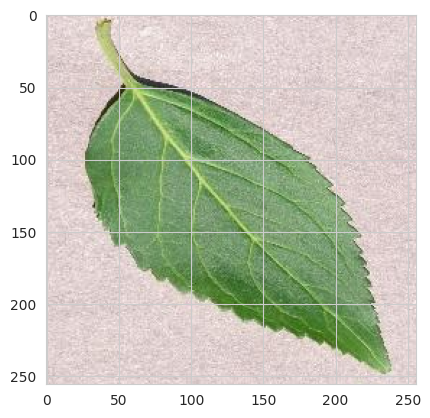

Validation set
Image shape: (256, 256, 3), Label: healthy


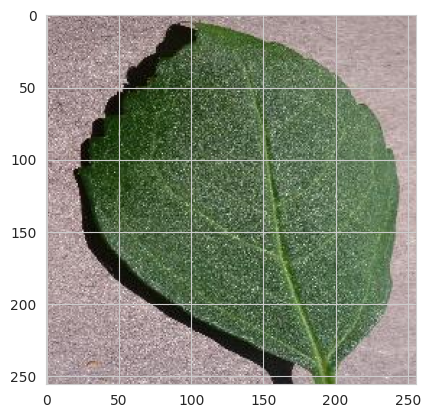

Validation set
Image shape: (256, 256, 3), Label: healthy


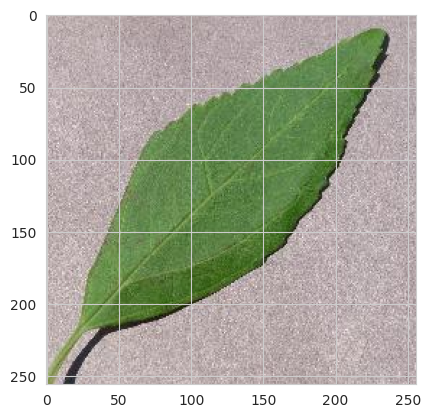

Test set
Image shape: (256, 256, 3), Label: healthy


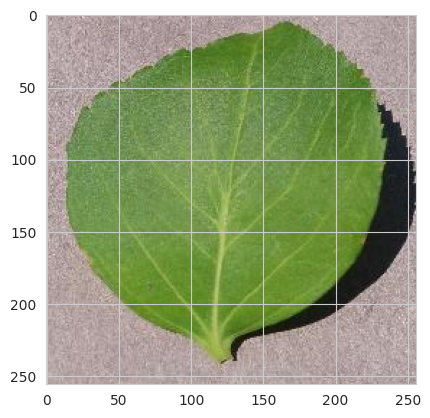

Test set
Image shape: (256, 256, 3), Label: healthy


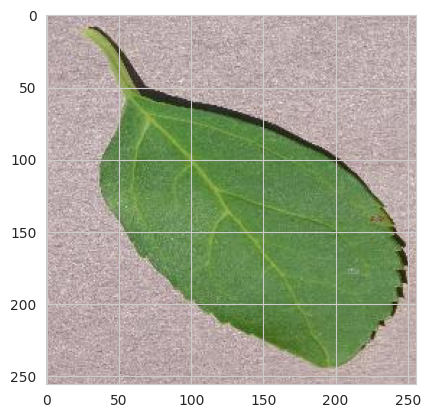

Test set
Image shape: (256, 256, 3), Label: healthy


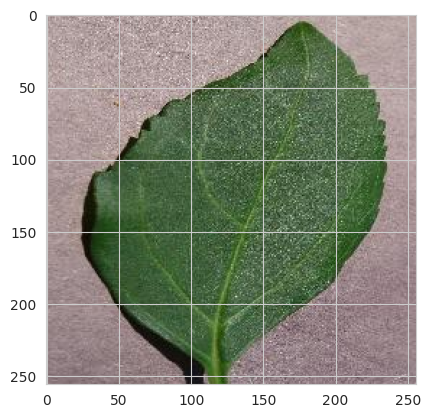

In [29]:
import numpy as np
import matplotlib.pyplot as plt

label_mapping = {0: 'healthy', 1: 'powdery_mildew'}
image_count = 0

imgs, labels = validation_set.next() 
shuffled_indices = np.random.permutation(len(labels)) 
imgs_shuffled = imgs[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

for img, label in zip(imgs_shuffled, labels_shuffled):
    label_text = label_mapping[label]
    print("Validation set") 
    print(f"Image shape: {img.shape}, Label: {label_text}")
    plt.imshow(img)
    plt.show()
    image_count += 1
    if image_count >= 3:
        break

label_mapping = {0: 'healthy', 1: 'powdery_mildew'}
image_count = 0

imgs, labels = test_set.next() 
shuffled_indices = np.random.permutation(len(labels))  # Shuffle indices
imgs_shuffled = imgs[shuffled_indices]
labels_shuffled = labels[shuffled_indices]

for img, label in zip(imgs_shuffled, labels_shuffled):
    label_text = label_mapping[label]
    print("Test set") 
    print(f"Image shape: {img.shape}, Label: {label_text}")
    plt.imshow(img)
    plt.show()
    image_count += 1
    if image_count >= 3:
        break

## Save

In [30]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['/workspace/mildew-detection/outputs/v3/class_indices.pkl']

---

# Model creation

---

## ML Model

### Import model packages

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

## Model

In [44]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [45]:
create_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

### Early stopping

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [47]:
model = create_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-05-26 20:34:00.002928: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 196s 1s/step - loss: 0.2860 - accuracy: 0.8649 - val_loss: 0.0495 - val_accuracy: 0.9833
Epoch 2/25
147/147 [==============================] - 211s 1s/step - loss: 0.0534 - accuracy: 0.9843 - val_loss: 0.0941 - val_accuracy: 0.9738
Epoch 3/25
147/147 [==============================] - 200s 1s/step - loss: 0.0702 - accuracy: 0.9785 - val_loss: 0.0443 - val_accuracy: 0.9929
Epoch 4/25
147/147 [==============================] - 204s 1s/step - loss: 0.0704 - accuracy: 0.9764 - val_loss: 0.0766 - val_accuracy: 0.9786
Epoch 5/25
147/147 [==============================] - 247s 2s/step - loss: 0.0254 - accuracy: 0.9897 - val_loss: 0.0268 - val_accuracy: 0.9952
Epoch 6/25
147/147 [==============================] - 318s 2s/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.0628 - val_accuracy: 0.9833
Epoch 7/25
147/147 [==============================] - 316s 2s/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.0421 - val_accuracy: 0.9905

## Save model

In [48]:

model.save('outputs/v1/mildew_detection_model.h5')

---

# Model Performace

---

## Model Evaluation

In [11]:
from keras.models import load_model
model = load_model('/workspace/mildew-detection/outputs/v1/mildew_detection_model.h5')

In [15]:
evaluation = model.evaluate(test_set)

NameError: name 'test_set' is not defined

## Model learning curve

In [ ]:
import pandas as pd

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Save evaluation pickle

In [ ]:
import joblib

joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

## Predict on new data

Load a random image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select healthy or powdery mildew

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

Predict class probabilities

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
